Importing training data from kaggle https://www.kaggle.com/datasets/tamzidhasan/protein-secondary-structure-casp12-cb513-ts115?resource=download

In [63]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
train_df = pd.read_csv('mini_training_data.csv')
print(f'Number of entries is {len(train_df)}')

Number of entries is 999


In [ ]:
test_df = pd.read_csv('testing_data.csv')
print(f'Number of entries is {len(test_df)}')

Number of entries is 513


In [ ]:
val_df = pd.read_csv('validation_data.csv')
print(f'Number of entries is {len(val_df)}')

Number of entries is 2170


In [30]:
print(train.columns)

Index(['seq', 'sst3', 'sst8'], dtype='object')


In the data imported from kaggle we have 3 columns first 'seq' which is input sequence 'sst3' where the output is classified into 3 categories - (α-helix [H], β-sheet [E], or coil [C]). In sst8 input is classified into 8 categories which is probably not related to this problem statement.

In [31]:
# Inspect first few rows
print(train.head())
# Extract sequences and labels
sequences = train['seq'].tolist()
labels = train['sst3'].tolist()
# Check lengths
for i in range(3):  # print a few examples
    print(f"Protein {i+1}:")
    print("Sequence :", sequences[i])
    print("Structure:", labels[i])
    print("Length   :", len(sequences[i]), "==", len(labels[i]))

                                                 seq  \
0  AETVESCLAKSHTENSFTNVXKDDKTLDRYANYEGCLWNATGVVVC...   
1  ASQEISKSIYTCNDNQVXEVIYVNTEAGNAYAIISQVNEXIPXRLX...   
2  XGSSHHHHHHSSGRENLYFQGXNISEINGFEVTGFVVRTTNADEXN...   
3  SNADYNRLSVPGNVIGKGGNAVVYEDAEDATKVLKMFTTSQSNEEV...   
4  DTVGRPLPHLAAAMQASGEAVYCDDIPRYENELFLRLVTSTRAHAK...   

                                                sst3  \
0  CCCHHHHHCCCCEEEEEECCEECCCCCCEEEEECCEEEEEEEEEEE...   
1  CCCCEEEEEEEECCCEEEEEEEEECCCCCEEEEEEECCEEEEEEEE...   
2  CCCCCCCCCCCCCCCCCEEEEEEEEEECCEEEEEEEEEECHHHHHC...   
3  CCCCCCCCCCEEEEEEECCCEEEEEECCCCCEEEEEECCCCCHHHH...   
4  CCCCCCCCCCCHHHHHCCCCCCHHHCCCCCCCEEEEEEECCCCCEE...   

                                                sst8  
0  CCCHHHHHTSCCEEEEEESCEECTTTCCEEEEETTEEEEEEEEEEE...  
1  CCCCEEEEEEEETTTEEEEEEEEECTTSCEEEEEEETTEEEEEEEE...  
2  CCCCCCCCCCCCCCCCCEEEEEEEEEECCEEEEEEEEEECHHHHHS...  
3  CCCCCCCCCCEEEEEEECSSEEEEEETTCTTEEEEEESSCCCHHHH...  
4  CCTTSCCCCTTHHHHHTTCSCCGGGSCCCTTCEEEEEEECSSSSEE..

In [32]:
#Assigning number to inputs
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_IDX = {aa: i for i, aa in enumerate(AMINO_ACIDS)}
LABELS = {'H': 0, 'E': 1, 'C': 2}
NUM_CLASSES = 3
print(f"Number of different kind of amino acids is {len(AA_TO_IDX)}")

Number of different kind of amino acids is 20


As the secondary structure of the amino acid changes with the surrounding amino acids, we will be taking a batch size and train the model.

In [46]:
WINDOW_SIZE = 50 # For each amino acid we look 15//2 = 7 times on left and right
PAD_CHAR = 'X'  # As X is not a amino acid we use it a dummy amnio acid when batch size is less than mentioned above.
BATCH_SIZE = 32  # We update the parameters once every batch
EPOCHS = 5  # Number of time we go through the entire dataset

In [47]:
# Converting each amino acid's idenity as vector
def one_hot(aa):
    vec = [0] * 20
    if aa in AA_TO_IDX:
        vec[AA_TO_IDX[aa]] = 1
    return vec

In [48]:
def pad_sequence(seq, pad_size):
    return PAD_CHAR * pad_size + seq + PAD_CHAR * pad_size

In [49]:
"""def encode_window(seq, i, window_size):
    half_window = window_size // 2
    left = max(0, i - half_window)          # Start of window (handles boundaries)
    right = min(len(seq), i + half_window + 1)  # End of window
    window = seq[left:right]                 # Extract centered window
    
    # Pad with 'X' if window is smaller than window_size (near sequence ends)
    pad_left = half_window - (i - left)      # Calculate left padding needed
    pad_right = half_window - (right - i - 1) # Calculate right padding needed
    window = (PAD_CHAR * pad_left) + window + (PAD_CHAR * pad_right)
    
    # Convert to one-hot and flatten
    return torch.tensor([one_hot(aa) for aa in window], dtype=torch.float).flatten()"""

"def encode_window(seq, i, window_size):\n    half_window = window_size // 2\n    left = max(0, i - half_window)          # Start of window (handles boundaries)\n    right = min(len(seq), i + half_window + 1)  # End of window\n    window = seq[left:right]                 # Extract centered window\n    \n    # Pad with 'X' if window is smaller than window_size (near sequence ends)\n    pad_left = half_window - (i - left)      # Calculate left padding needed\n    pad_right = half_window - (right - i - 1) # Calculate right padding needed\n    window = (PAD_CHAR * pad_left) + window + (PAD_CHAR * pad_right)\n    \n    # Convert to one-hot and flatten\n    return torch.tensor([one_hot(aa) for aa in window], dtype=torch.float).flatten()"

In [58]:
def encode_window(seq, i, window_size):
    window = seq[i:i+window_size]
    return torch.tensor([one_hot(aa) for aa in window], dtype=torch.float).flatten()

In [51]:
class ProteinDataset(Dataset):
    def __init__(self, dataframe):
        self.samples = []
        for _, row in dataframe.iterrows():
            seq = row['seq']
            sst = row['sst3']
            padded_seq = pad_sequence(seq, WINDOW_SIZE // 2)
            for i in range(len(seq)):
                x = encode_window(padded_seq, i, WINDOW_SIZE)
                y = LABELS.get(sst[i], 2)
                self.samples.append((x, y))
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [52]:
class SecondaryStructureMLP(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(0.3)  # Added dropout for regularization
        self.fc2 = nn.Linear(hidden_size, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        return self.fc2(x)

In [53]:
train_dataset = ProteinDataset(train_df)
val_dataset = ProteinDataset(val_df)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
model = SecondaryStructureMLP(WINDOW_SIZE * 20)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [56]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_weights = None


In [59]:
PATIENCE = 3  # Number of epochs to wait before stopping if no improvement
# Initialize these before your training loop
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_weights = None

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_total_loss = 0
    train_total_correct = 0
    train_total_samples = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_total_correct += (preds == y_batch).sum().item()
        train_total_samples += y_batch.size(0)
    
    train_epoch_loss = train_total_loss / len(train_loader)
    train_epoch_accuracy = 100.0 * train_total_correct / train_total_samples
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    # Validation phase
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_total_correct += (preds == y_batch).sum().item()
            val_total_samples += y_batch.size(0)
    
    val_epoch_loss = val_total_loss / len(val_loader)
    val_epoch_accuracy = 100.0 * val_total_correct / val_total_samples
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Epoch {epoch+1}")
    print(f"Train - Loss: {train_epoch_loss:.4f} | Accuracy: {train_epoch_accuracy:.2f}%")
    print(f"Val   - Loss: {val_epoch_loss:.4f} | Accuracy: {val_epoch_accuracy:.2f}%")
    print("-" * 50)

    # Early stopping check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_weights = model.state_dict().copy()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_weights)
            break

Epoch 1
Train - Loss: 0.7047 | Accuracy: 69.78%
Val   - Loss: 0.7786 | Accuracy: 65.87%
--------------------------------------------------
Epoch 2
Train - Loss: 0.6837 | Accuracy: 70.69%
Val   - Loss: 0.7843 | Accuracy: 65.82%
--------------------------------------------------
Epoch 3
Train - Loss: 0.6678 | Accuracy: 71.51%
Val   - Loss: 0.7943 | Accuracy: 65.42%
--------------------------------------------------
Epoch 4
Train - Loss: 0.6558 | Accuracy: 72.15%
Val   - Loss: 0.8015 | Accuracy: 65.30%
--------------------------------------------------
Early stopping at epoch 4


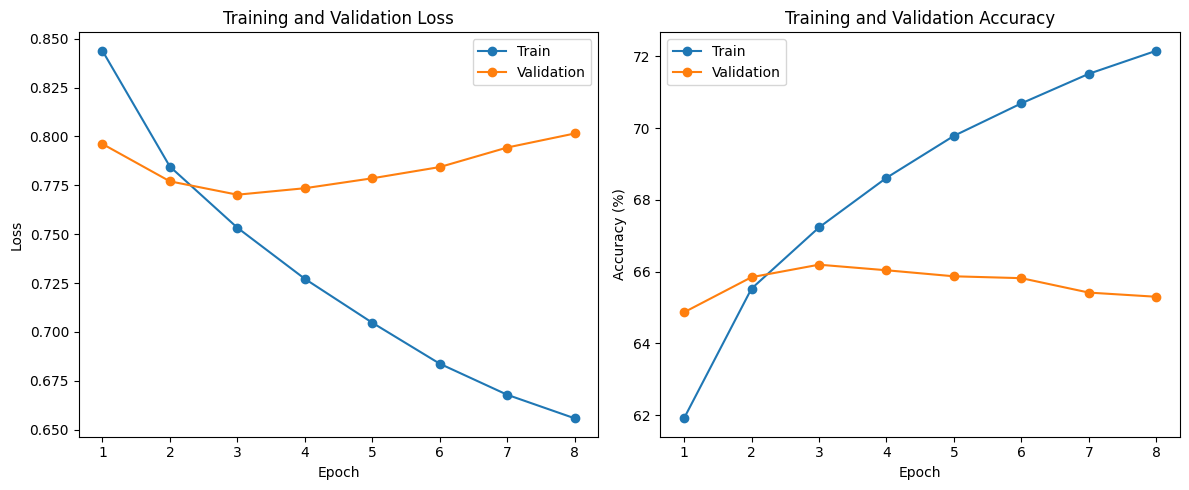

In [60]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation', marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train', marker='o')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation', marker='o')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
print("\nFinal Metrics:")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")


Final Metrics:
Best Validation Loss: 0.7786
Best Validation Accuracy: 66.19%


In [66]:
# ===== ADD THIS TEST EVALUATION CODE AFTER YOUR EXISTING CODE =====

# 1. Load test data (assuming same format as training data)
test_df = pd.read_csv('testing_data.csv')  # Replace with your test file path

# 2. Create test dataset and loader (using your existing ProteinDataset class)
test_dataset = ProteinDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Evaluate on test set
model.eval()  # Set model to evaluation mode
test_correct = 0
test_total = 0
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        test_total += y_batch.size(0)
        test_correct += (preds == y_batch).sum().item()
        
        # For additional metrics
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())

# 4. Calculate and display test accuracy
test_accuracy = 100.0 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# (Optional) Detailed classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_true, all_preds, 
                          target_names=['Helix (H)', 'Strand (E)', 'Coil (C)']))

print("\nConfusion Matrix:")
print(confusion_matrix(all_true, all_preds))


Test Accuracy: 64.46%

Classification Report:
              precision    recall  f1-score   support

   Helix (H)       0.66      0.68      0.67     49182
  Strand (E)       0.57      0.45      0.51     31970
    Coil (C)       0.66      0.71      0.68     63208

    accuracy                           0.64    144360
   macro avg       0.63      0.62      0.62    144360
weighted avg       0.64      0.64      0.64    144360


Confusion Matrix:
[[33541  3838 11803]
 [ 5953 14519 11498]
 [11152  7059 44997]]
